## 手动实现GRU

In [1]:
import math

import torch
from torch import nn
import numpy as np

from datasets import *

In [2]:
## 第一部分：网络定义
class My_GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.gates = nn.Linear(input_size+hidden_size, hidden_size*2)
        # 用于计算candidate hidden state
        self.hidden_transform = nn.Linear(input_size+hidden_size, hidden_size)
        
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        
        self.output = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, output_size)
        )
            
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)
                
    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)
        
        h = torch.zeros(batch_size, self.hidden_size).to(x.device)
        y_list = []
        for i in range(seq_len):
            update_gate, reset_gate = self.gates(torch.cat([x[:, i, :], h], dim=-1)).chunk(2, -1)
            update_gate, reset_gate = (self.sigmoid(gate) for gate in (update_gate, reset_gate))
            candidate_hidden = self.tanh(self.hidden_transform(torch.cat([x[:, i, :], reset_gate * h], dim=-1)))
            h = (1-update_gate) * h + update_gate * candidate_hidden
            y_list.append(self.output(h))
        return torch.stack(y_list, dim=1), h

In [3]:
##第二部分：加载数据集，生成迭代器
KrakowData = KrakowDataset()
train_set, val_set, test_set = KrakowData.construct_set(0.6, 0.2)

batch_size = 64
train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
val_loader = data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)
test_loader = data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)
train_loader

In [4]:
##第三部分：测试指标RMSE、MAE和MAPE
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_index = (y_true > 0)
    y_true = y_true[non_zero_index]
    y_pred = y_pred[non_zero_index]

    mape = np.abs((y_true - y_pred) / y_true)
    mape[np.isinf(mape)] = 0
    return np.mean(mape) * 100

In [6]:
#第四部分：模型初始化并进行训练
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 64
output_size = 1
seq_len = 12
lr = 0.0001
epochs = 80
loss_func = nn.MSELoss()

my_gru = My_GRU(input_size, hidden_size, output_size).to(device)

optimizer = torch.optim.Adam(my_gru.parameters(), lr)

In [7]:
from utils import *

train_loss_lst, val_loss_lst, \
    train_score_lst, val_score_lst, stop_epoch = train(my_gru, train_loader, val_loader, test_loader,
                                                       loss_func, KrakowData.denormalize, optimizer, epochs,
                                                       early_stop=20, device=device, output_model=None)

*** epoch5, train loss 0.0024, train rmse 13.5599, val loss 0.0002, val rmse 3.848593, time use 1.747s
*** epoch10, train loss 0.0015, train rmse 10.9140, val loss 0.0001, val rmse 3.342934, time use 1.689s
*** epoch15, train loss 0.0012, train rmse 9.5684, val loss 0.0001, val rmse 3.201902, time use 1.690s
*** epoch20, train loss 0.0010, train rmse 8.9112, val loss 0.0002, val rmse 3.591769, time use 1.779s
*** epoch25, train loss 0.0010, train rmse 8.6194, val loss 0.0001, val rmse 2.937654, time use 1.756s
*** epoch30, train loss 0.0009, train rmse 8.3333, val loss 0.0002, val rmse 3.430401, time use 1.722s
*** epoch35, train loss 0.0009, train rmse 8.1798, val loss 0.0001, val rmse 3.280920, time use 1.631s
*** epoch40, train loss 0.0009, train rmse 8.1401, val loss 0.0001, val rmse 3.011567, time use 1.664s
*** epoch45, train loss 0.0008, train rmse 7.9791, val loss 0.0001, val rmse 2.964283, time use 1.677s
*** epoch50, train loss 0.0008, train rmse 7.9931, val loss 0.0001, val 

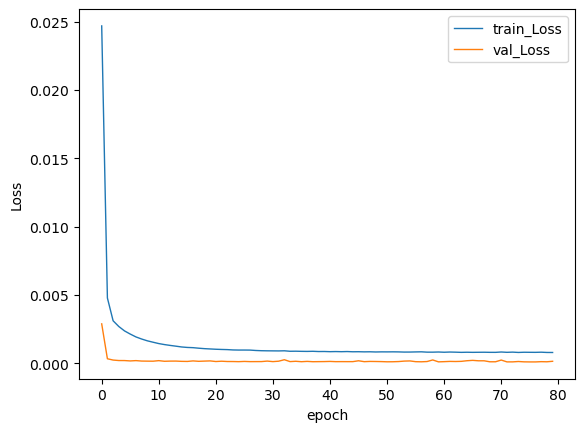

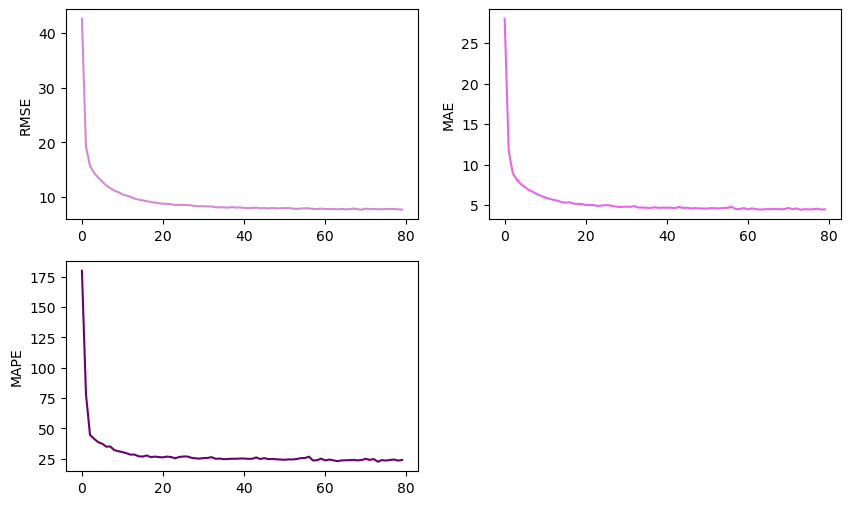

In [8]:
#第五部分：结果可视化
visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)

## 调用torch.nn实现GRU

In [9]:
#第一部分：调用RNN并进行训练
from utils import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 64
output_size = 1
seq_len = 12
lr = 0.0001
epochs = 80
loss_func = nn.MSELoss()

nn_gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True).to(device)
out_linear = nn.Sequential(nn.Linear(hidden_size, 1),
                           nn.LeakyReLU()).to(device)

optimizer = torch.optim.Adam(list(nn_gru.parameters()) + list(out_linear.parameters()), lr)

train_loss_lst, val_loss_lst, \
    train_score_lst, val_score_lst, stop_epoch = train(nn_gru, train_loader, val_loader, test_loader,
                                                       loss_func, KrakowData.denormalize, optimizer, epochs,
                                                       early_stop=20, device=device, output_model=out_linear)

*** epoch5, train loss 0.0038, train rmse 17.2588, val loss 0.0004, val rmse 5.578017, time use 0.274s
*** epoch10, train loss 0.0025, train rmse 13.9230, val loss 0.0002, val rmse 3.931776, time use 0.260s
*** epoch15, train loss 0.0018, train rmse 11.9572, val loss 0.0002, val rmse 3.937601, time use 0.276s
*** epoch20, train loss 0.0015, train rmse 10.5964, val loss 0.0002, val rmse 3.397207, time use 0.257s
*** epoch25, train loss 0.0013, train rmse 9.8821, val loss 0.0001, val rmse 3.249517, time use 0.263s
*** epoch30, train loss 0.0011, train rmse 9.3662, val loss 0.0001, val rmse 3.210967, time use 0.274s
*** epoch35, train loss 0.0011, train rmse 9.0138, val loss 0.0001, val rmse 3.151825, time use 0.249s
*** epoch40, train loss 0.0010, train rmse 8.6875, val loss 0.0001, val rmse 3.069786, time use 0.283s
*** epoch45, train loss 0.0010, train rmse 8.6096, val loss 0.0001, val rmse 3.158647, time use 0.253s
*** epoch50, train loss 0.0009, train rmse 8.4756, val loss 0.0001, va

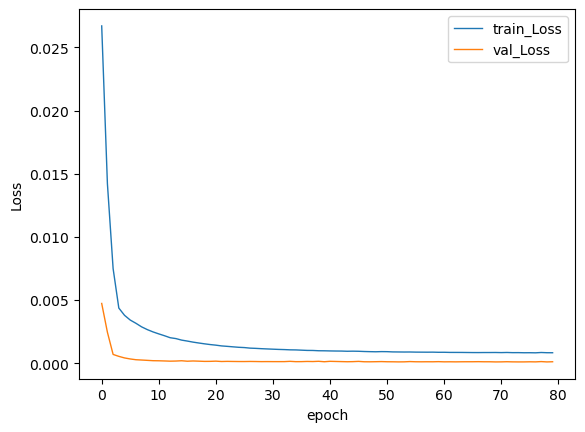

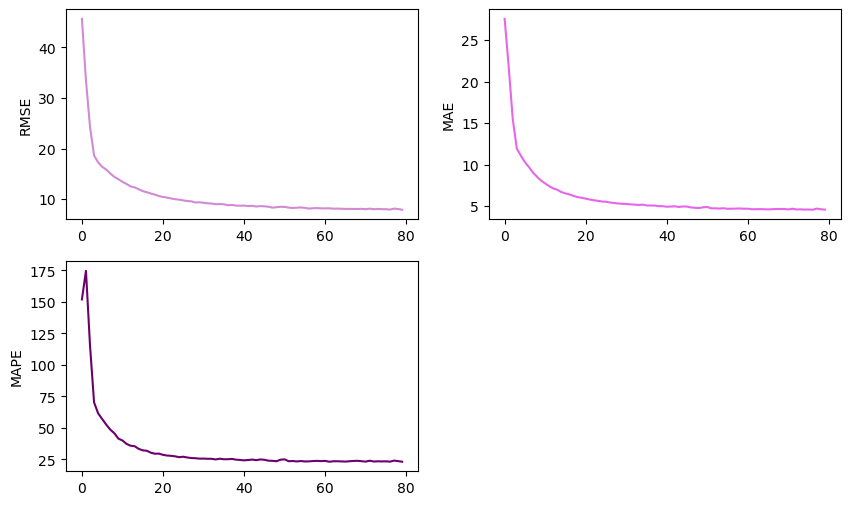

In [10]:
#第二部分：结果可视化
visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)